# Self-driving Car Nanodegree - Term 1
## Project 1-5: Vehicle Detection & Lane Tracking

In this project, I will be more focused on the topic that I learnt after the 4th project, which is for vehicle detection purpose. I will use the similar approach for lane tracking solution that I used from the previous project.

### Import required packages

In [4]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
%matplotlib inline

## 1. Import Test Images

In the first section, I prepare the data for classifier and testing purpose, including: `test_images`, `vehicles`, and `non_vehicles`. The `vehicles`, and `non_vehicles` dataset was downloaded through [this link for the vehicle dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [this link for the non-vehicle dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)

In [5]:
test_images = glob.glob('test_images/test*.jpg')
vehicles = glob.glob('vehicles/*/*.png')
non_vehicles = glob.glob('non-vehicles/*/*.png')

print(test_images[0])
print(vehicles[0])
print(non_vehicles[0])

test_images\test1.jpg
vehicles\GTI_Far\image0000.png
non-vehicles\Extras\extra1.png


## 2. Features Extraction

The function for features extraction purposes (color histogram features, binned color features, and HOG) are based from the method that was taught from previous lessons

In [6]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGb channels separately
    rhist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    
    #Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    #Return concatenated histogram
    return hist_features

# Function test
# test_image = mpimg.imread(test_images[0])
# test_hist_features = color_hist(test_image)
# if test_hist_features.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.plot(test_hist_features)
#     plt.title("Combined Color Histogram")

In [7]:
# Define a function to compute binned color features
def bin_spatial(img, size=(16, 16)):
    # Use cv2.resize().ravel() to create the feature vector
    return cv2.resize(img, size).ravel()

# Funtion test
# test_image = mpimg.imread(test_images[0])
# test_feature_vec = bin_spatial(test_image)
# if test_feature_vec.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.plot(test_feature_vec)
#     plt.title("Binned Color Histogram")

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block
                , vis=True, feature_vec=False):
    # Call with 2 outputs if  vis is True
    if vis==True:
        features, hog_image = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=True,
                                 visualise=vis, feature_vector=feature_vec)
        return feature_vec, hog_image
    
    # otherwise, call with 1 output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function test
# test_image = mpimg.imread(test_images[0])
# test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
# test_features, test_hog_image = get_hog_features(test_image, orient=9
#                                   , pix_per_cell=8
#                                   , cell_per_block=2
#                                   , vis=True, feature_vec=False)
# if test_features != False:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.imshow(test_hog_image, cmap='gray')
#     plt.title("HOG Visualization")

In [9]:
# Define a function to extract features from a list of images
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                    hist_bins=32, hist_range=(0, 256)):
    # Create a list to append features vectors to
    features = []
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Append the new feature vector to the feature list
        features.append(np.concatenate((spatial_features, hist_features)))
    
    # Return list of feature vectors
    return features

# Function test
# test_car_features = extract_color_features(vehicles[0:50], cspace='RGB', spatial_size=(32, 32),
#                                hist_bins=32, hist_range=(0, 256))
# if len(test_car_features) == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

In [10]:
# Define a function  to extract HOG features from a list of images
def extract_hog_features(imgs, cspace='RGB', orient=9,
                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file
                            )
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=False))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                           orient, pix_per_cell, cell_per_block,
                                           vis=False, feature_vec=False)
        
        # Append the new feature vector to the features list
        features.append(hog_features)
        
        # Return list of feature vectors
        return features
    
# Function test
# test_car_features = extract_hog_features(vehicles, cspace='RGB', orient=9,
#                          pix_per_cell=8, cell_per_block=2, hog_channel=0)

# if len(test_car_features) == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

In [11]:
# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0,
                     vis=False, feature_vec=True,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=vis, feature_vec=feature_vec))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=feature_vec)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Function test
# images = vehicles[0:50]
# test_car_features = extract_features(images, color_space='RGB', spatial_size=(16, 16), hist_bins=16, 
#                                      orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                                      vis=False, feature_vec=True,
#                                      spatial_feat=True, hist_feat=True, hog_feat=True)

# if len(test_car_features) == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

## 3. Classifier

In order to train a classifier, we need to normalize the data first by using `StandardScaler` from `sklearn.preprocessing` which is defined in `combine_features()`. To apply the normalization into specific dataset, use `fit_scaler()` and `apply_scaler()`

In [12]:
# Define a function to combine and normalize the data for classifier purpose
def combine_features(x_features, y_features):
    # Create an array stack of feature vectors
    X = np.vstack((x_features, y_features)).astype(np.float64)
    
    # Create a horizontal array stack of label
    y = np.hstack((np.ones(len(x_features)), np.zeros(len(y_features))))
    
    return X, y

def fit_scaler(X):
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    return X_scaler

def apply_scaler(X_scaler, X):
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X

# Function test
# test_car_features = extract_color_features(vehicles, cspace='RGB', spatial_size=(16, 16),
#                                hist_bins=32, hist_range=(0, 256))
# test_noncar_features = extract_color_features(non_vehicles, cspace='RGB', spatial_size=(16, 16),
#                                hist_bins=32, hist_range=(0, 256))
# test_X, test_y = combine_features(x_features=test_car_features, y_features=test_noncar_features)
# test_X_scaler = fit_scaler(test_X)
# test_scaled_X = apply_scaler(test_X_scaler, test_X)

# if test_scaled_X.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     fig = plt.figure(figsize=(12, 4))
#     plt.subplot(131)
#     plt.imshow(mpimg.imread(vehicles[0]))
#     plt.title("Original Image")
#     plt.subplot(132)
#     plt.plot(test_X[0])
#     plt.title("Raw features")
#     plt.subplot(133)
#     plt.plot(test_scaled_X[0])
#     plt.title("Combine & Normalized Features")
#     fig.tight_layout()

After that, we need to split both datasets into randomized training and test set. The dataset should be balanced, which is the number of car and non-car images should be roughly equal to avoid the class imbalance. Because I am using the provided vehicles and non-vehicles dataset that have been balanced, this imbalanceness case has been avoided. For splitting purpose, I define it in `split_train_test_test()`

In [13]:
print("Total number of vehicle images: ", len(vehicles))
print("Total number of non-vehicle images: ", len(non_vehicles))
print("Ratio vehicle : non-vehicle: ", np.around(len(vehicles) / np.add(len(vehicles), len(non_vehicles)), decimals=1)
      , ":"
      , np.around(len(non_vehicles) / np.add(len(vehicles), len(non_vehicles)), decimals=1))

Total number of vehicle images:  8792
Total number of non-vehicle images:  8968
Ratio vehicle : non-vehicle:  0.5 : 0.5


In [14]:
# Define a function to split the data into randomize train and test set
def split_train_test_set(X, y, test_size=0.2):
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    return X_train, X_test, y_train, y_test

# Function test
# test_X_train, test_X_test, test_y_train, test_y_test = split_train_test_set(test_X, test_y)
# if test_X_train.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

Then, train the classifier by using a Linear Support Vector Machine that is defined at `linear_SVC()`

In [15]:
# Define a function to train the classifier by using a Linear SVM
def linear_SVC(X_train, X_test, y_train, y_test):
    # Use a linear SVC
    svc = LinearSVC()
    
    # Check the training time for the SVC
    t_in = time.time()
    svc.fit(X_train, y_train)
    t_out = time.time()
    print(round(t_out - t_in, 2), "seconds to train SVC...")
    
    # Check the score of the SVC
    svc_score = round(svc.score(X_test, y_test), 4)
    print("Test accuracy of SVC: ", svc_score)
    
    # Check the prediction time for a single sample
    t_in = time.time()
    n_predict = 10
    svc_prediction = svc.predict(X_test[0 : n_predict])
    print("My SVC predicts: ", svc_prediction)
    print("For these", n_predict, "labels: ", y_test[0 : n_predict])
    t_out = time.time()
    print(round(t_out - t_in, 5), "seconds to predict", n_predict, "labels with SVC")

# Function test
# test_X_train = apply_scaler(test_X_scaler, test_X_train)
# test_X_test = apply_scaler(test_X_scaler, test_X_test)
# linear_SVC(test_X_train, test_X_test, test_y_train, test_y_test)

## 4. Sliding Windows

On here, I define a sliding window function `slide_windows()` to perform a sliding window search on an image.

In [16]:
# Define a function that takes an image, start and stop positions in both x and y window size (x and y dimension)
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions have not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate each window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
        
    # Return the list of windows
    return window_list

# Function test
# test_image = mpimg.imread(test_images[0])
# test_windows = slide_window(test_image)
# if len(test_windows) == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

After that, I create a new function, `draw_boxes()`, to draw the box with particular coordination on the image

In [17]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

# Function test
# test_img = mpimg.imread(test_images[0])
# test_windows = slide_window(test_img)
# test_window_img = draw_boxes(test_img, test_windows)    
# if test_window_img.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.imshow(test_img)

In order to search over all the windows defined by `slide_windows()`, extract features at each window position, and predict with your classifier on each set of features. To do that, I need to define another feature, `single_img_features()`. This function is very similar to extract_features() or extract_hog_features(). However, this function is just for a single image rather than list of images

In [18]:
# Define a function to extract features from a single image window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        vis=False, feature_vec=True,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=vis, feature_vec=feature_vec))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel],
                                           orient, pix_per_cell, cell_per_block,
                                           vis=vis, feature_vec=feature_vec)
        # Append features to list
        img_features.append(hog_features)
    
    # Return concatenated array of features
    return np.concatenate(img_features)

# test_image = mpimg.imread(test_images[0])
# test_image_feature = single_img_features(test_image, feature_vec=True)

# if len(test_image_feature) == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")

In [19]:
# Define a function to pass an image and the list of windows to be searched
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, vis=False, feature_vec=True,
                   spatial_feat=True,hist_feat=True, hog_feat=True):
    # Create an empty list to receive positive detection windows
    on_windows = []

    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original 
        test_img = cv2.resize(img[window[0][1] : window[1][1], window[0][0] : window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                      spatial_size=spatial_size, hist_bins=hist_bins,
                                      orient=orient, pix_per_cell=pix_per_cell,
                                      cell_per_block=cell_per_block, hog_channel=hog_channel,
                                      vis=vis, feature_vec=feature_vec,
                                      spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predict using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

## 5. Search & Classify Testing

In this section, I start to conduct search and classification testing using all of the function that I have been defined before. At the beginning, I put the hyperparameters into a separate row for convenience purpose

In [20]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

xy_window_size = (64, 64)
xy_overlap_size = (0.85, 0.85)
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

In [21]:
car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Total vehicles: ", len(car_features))

notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print("Total non-vehicles: ", len(notcar_features))

X, y = combine_features(car_features, notcar_features)
X_scaler = fit_scaler(X)
scaled_X = apply_scaler(X_scaler, X)
    
X_train, X_test, y_train, y_test = split_train_test_set(scaled_X, y)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

D:\Programs\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total vehicles:  8792
Total non-vehicles:  8968
Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2432


In [22]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t_in = time.time()
svc.fit(X_train, y_train)
t_out = time.time()
print(round(t_out - t_in, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

6.7 Seconds to train SVC...
Test Accuracy of SVC =  0.9794


D:\Programs\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


37.97 Seconds to process test images


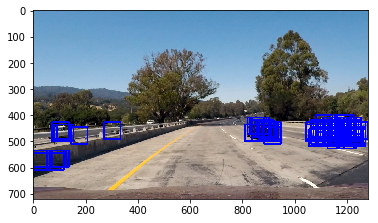

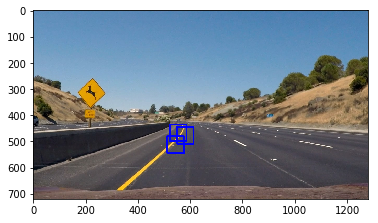

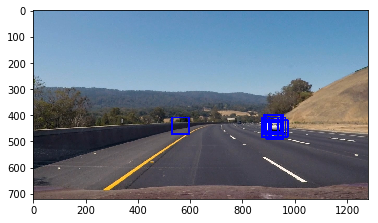

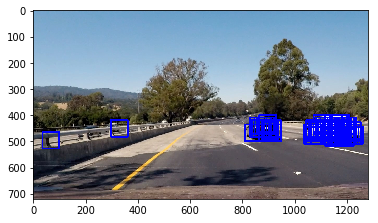

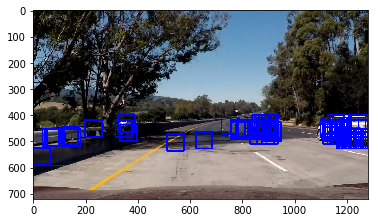

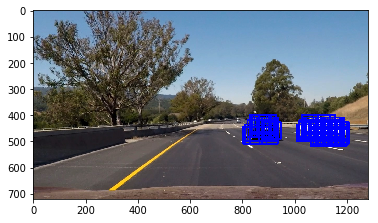

In [23]:
# Check the prediction time for a single sample
t_in=time.time()

for test_image in test_images:
    img = mpimg.imread(test_image)
    
    draw_img = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window_size, xy_overlap=xy_overlap_size)
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)   
    plt.figure() 
    plt.imshow(window_img)
    
t_out = time.time()
print(round(t_out - t_in, 2), 'Seconds to process test images')

Based on the result below, my classifier have successfully identified the vehicles on every test images. However, my classifier also identitied several false positive examples. To put it into concern, I need to apply a better approach.

## 6. Heat-map Detection for False Positive Issue

To answer the false positive issue that was appeared on the test images above, I try to use heat-map detection as another approach in order to combine overlapping detections and remove false positives. To do this, I create a new function, `add_heat()`, which adds heat to a map for a list of bounding boxes.

In [24]:
# Define a function that add "heat" to a map for a list of bounding boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1] : box[1][1], box[0][0] : box[1][0]] += 1
        
    # Return updated heatmap
    return heatmap

# Function test
# test_image = mpimg.imread(test_images[0])
# heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# heat = add_heat(heat, hot_windows)

# if heat.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.imshow(heat)

After I create the heatmap, I need to apply thresholding method by creating `apply_threshold()` for the heatmap in order to remove false positive(s)

In [25]:
# Define a function that apply thresholding method for heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return threshold map
    return heatmap

# Function test
# heat = apply_threshold(heat,1)
# if heat.size == 0:
#     print("Function haven't worked properly")
# else:
#     print("OK!")
#     plt.imshow(heat)

By using the new vehicle detector, I wrap it up together at `draw_labeled_bboxes()`

In [43]:
# Define a function that wrap both 2 function above together
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected objects
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        width = (bbox[1][0]-bbox[0][0])/2.0
        height = (bbox[1][1]-bbox[0][1])/2.0
        
        # Draw the box on the image if the width and height are below particular point
        if width >= 10 and height >= 10:
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        
    # Return the image
    return img

# Function test
# heatmap = np.clip(heat, 0, 255)
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# plt.imshow(draw_img)

D:\Programs\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


94.5 54.0
45.0 36.0
31.5 31.5
99.0 49.5
40.5 31.5
54.0 40.5
76.5 54.0
49.5 45.0
85.5 54.0
37.32 Seconds to process test images


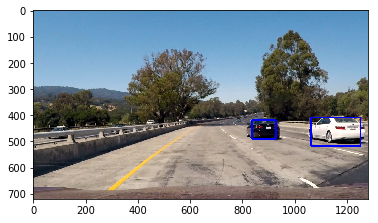

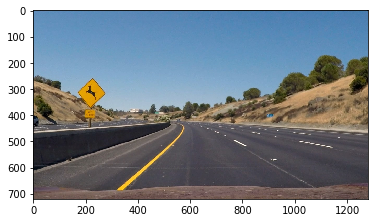

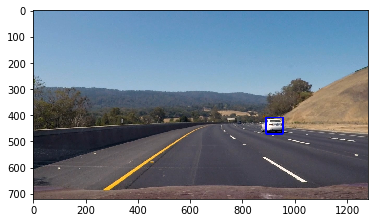

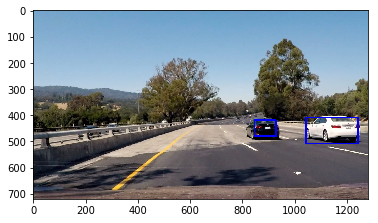

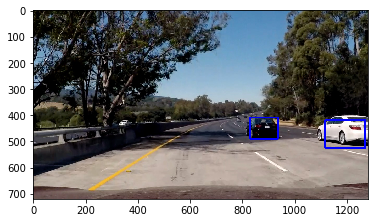

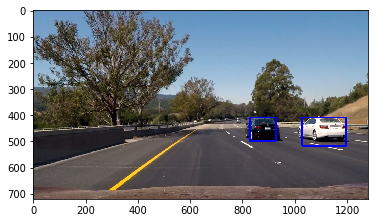

In [29]:
# Check the prediction time for a single sample
t_in=time.time()

for test_image in test_images:
    img = mpimg.imread(test_image)
    
    draw_img = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window_size, xy_overlap=xy_overlap_size)
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,5)
    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)

#     window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)   
    plt.figure() 
    plt.imshow(draw_img)
    
t_out = time.time()
print(round(t_out - t_in, 2), 'Seconds to process test images')

## 7. Lane Line

All of these functions were from the previous project

In [37]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return cv2.undistort(img, mtx, dist, None, mtx)

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

def mag_threshold(img, sobel_kernel=9, thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(magnitude) / 255
    magnitude = (magnitude / scale_factor).astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= thresh[0]) & (magnitude <= thresh[1])] = 1
    
    return binary_output

def dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_gradientx = np.absolute(sobelx)
    abs_gradienty = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_gradients = np.arctan2(abs_gradienty, abs_gradientx)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(abs_gradients)
    binary_output[(abs_gradients >= thresh[0]) & (abs_gradients <= thresh[1])] = 1
    
    return binary_output

def mag_dir_threshold_combined(img, mag_sobel_kernel=9, dir_sobel_kernel=15, mag_thresh=(30, 100), dir_thresh=(0.7, 1.3)):
    # Call Sobel Threshold to get the gradient x and y of sobel operator
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    
    # Get the magnitude gradient
    mag_binary = mag_threshold(img, sobel_kernel=mag_sobel_kernel, thresh=(mag_thresh[0], mag_thresh[1]))
    
    # Get the direction gradient
    dir_binary = dir_threshold(img, sobel_kernel=dir_sobel_kernel, thresh=(dir_thresh[0], dir_thresh[1]))
    
    # Combine all of these gradients above together
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

def mag_dir_satur_thresh(img, sobel_kernel_x=3, sobel_kernel_y=3, dir_kernel=11, mag_kernel=11,
                        sobel_x_thresh=(20,100), sobel_y_tresh=(20,100), mag_thresh=(30,100), dir_thresh=(0.7, 1.3), sat_thresh=(25, 255)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel_x, thresh=(sobel_x_thresh[0], sobel_x_thresh[1]))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel_y, thresh=(sobel_y_tresh[0], sobel_y_tresh[1]))
    
    sat_binary = saturation_thresh(img, thresh=(sat_thresh[0], sat_thresh[1]))
    mag_binary = mag_threshold(img, sobel_kernel=mag_kernel, thresh=(mag_thresh[0], mag_thresh[1]))
    dir_binary = dir_threshold(img, sobel_kernel=dir_kernel, thresh=(dir_thresh[0], dir_thresh[1]))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sat_binary == 1)] = 1
    
    return combined

def blue_threshold(img, thresh=(25, 255)):
    blue = img[:,:,2]
    blue_binary = np.zeros_like(blue)
    blue_binary[(blue >= thresh[0]) & (blue <= thresh[1])] = 1
    return blue_binary

def green_threshold(img, thresh=(25, 255)):
    green = img[:,:,1]
    green_binary = np.zeros_like(green)
    green_binary[(green >= thresh[0]) & (green <= thresh[1])] = 1
    return green_binary

def red_threshold(img, thresh=(25, 255)):
    red = img[:,:,0]
    red_binary = np.zeros_like(red)
    red_binary[(red >= thresh[0]) & (red <= thresh[1])] = 1
    return red_binary

def hue_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hue = hls[:,:,0]
    hue_binary = np.zeros_like(hue)
    hue_binary[(hue > thresh[0]) & (hue <= thresh[1])] = 1
    return hue_binary

def lightness_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    lightness = hls[:,:,1]
    lightness_binary = np.zeros_like(lightness)
    lightness_binary[(lightness > thresh[0]) & (lightness <= thresh[1])] = 1
    return lightness_binary

def saturation_thresh(img, thresh=(25, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    saturation_binary = np.zeros_like(saturation)
    saturation_binary[(saturation > thresh[0]) & (saturation <= thresh[1])] = 1
    return saturation_binary

def hist_normalization(img):
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])
    return img

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    img_size = [img.shape[1], img.shape[0]]
    
    vertices = np.array([
        [(0, img_size[1]-offset), (560, 450), (720, 450), (img_size[0], img_size[1]-offset)]
    ], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspective_transform(img, offset=50):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[0, img_size[1]-offset],
         [560, 450],
         [720, 450],
         [img_size[0], img_size[1]-offset]])
    dst = np.float32(
        [[200,img_size[1]],
         [200,0],
         [1160,0],
         [1160, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def detect_lane_lines(warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:, :], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped)) * 255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx

def calculate_lane_curvature(ploty, left_fit_m, right_fit_m, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    curvature = (left_curverad + right_curverad) / 2 
    center = (1.5 * left_curverad - right_curverad) / 2
    min_curvature = min(left_curverad, right_curverad)
    return left_curverad, right_curverad, center, curvature, min_curvature

def apply_to_original_image(img, warped, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    return result

def add_figures_to_image(result, curvature, center, min_curvature):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param result:
    """
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7
    center = center / 128 * 3.7
    
    x_axis = result.shape[1]*xm_per_pix
    centerImg = x_axis / 2
    vehicle_position = (center - centerImg) / 100
    
    if vehicle_position < 0:
        status = "left"
    else:
        status = "right"

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), status), (50, 100), font, 1,(255, 255, 255), 2)
    cv2.putText(result, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)

def image_pipeline(file, isImage=False):

    # Clear the plot
    plt.clf()
    
    if isImage == True:
        inputFile = mpimg.imread(file)
    else:
        inputFile = file
    
    M, Minv = perspective_transform(inputFile)
    shape = (inputFile.shape[1], inputFile.shape[0])
    threshold_img = mag_dir_satur_thresh(inputFile, 3, 3, 11, 11, (20,100), (20,100), (30,100), (0.7,1.3), (100,255))
    roi_img = region_of_interest(threshold_img)
    undistort_img = undistort(roi_img)
    bird_eye_img = cv2.warpPerspective(undistort_img, M, shape, flags=cv2.INTER_LINEAR)
    out_img, ploty, left_fit_m, right_fit_m, left_fitx, right_fitx = detect_lane_lines(bird_eye_img)
    left_curverad, right_curverad, center, curvature, min_curvature = calculate_lane_curvature(ploty, left_fit_m, right_fit_m, left_fitx, right_fitx)
    result = apply_to_original_image(inputFile, bird_eye_img, ploty, left_fitx, right_fitx, Minv)
    add_figures_to_image(result, curvature, center, min_curvature)
    return result

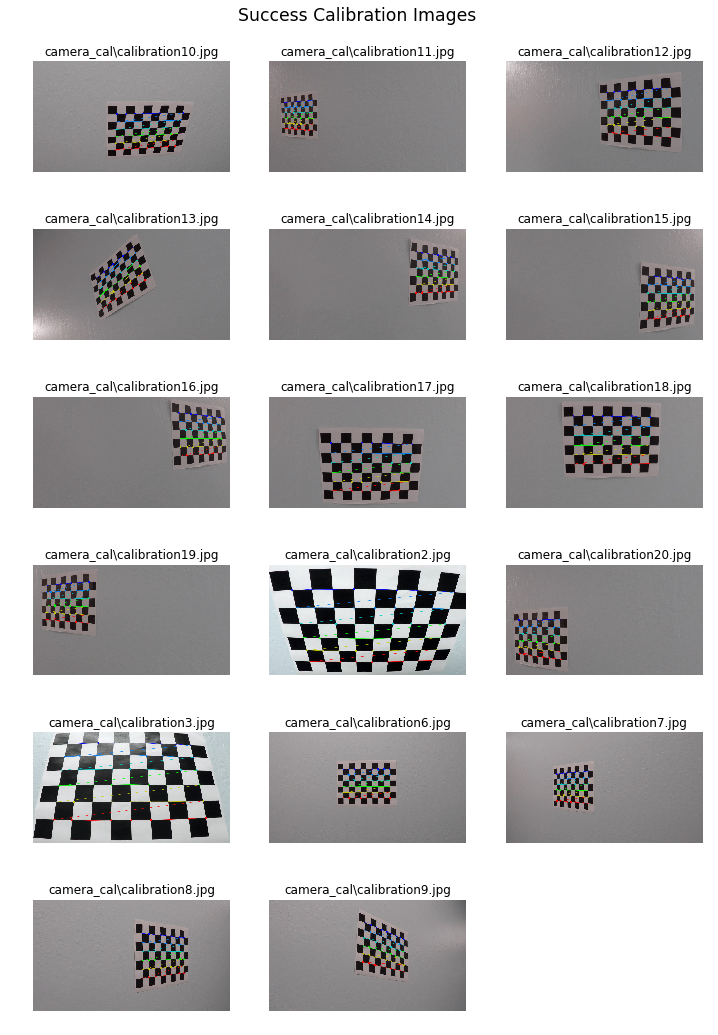

Success rate:  85.0 %


In [38]:
# Set up chessboard size to 9x6
x_chess = 9
y_chess = 6

# prepare objects points, like (0,0,0), (1,0,0), (2,0,0), ..., (6,5,0)
objp = np.zeros((y_chess*x_chess,3), np.float32)
objp[:,:2] = np.mgrid[0:x_chess, 0:y_chess].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of paths to calibration images
images = glob.glob('camera_cal/calibration*.jpg') 

# Calibration images that was failed to find corners
not_found = []

# plot the result
plt.figure(figsize=(12, 18))
plt.figtext(0.5, 0.9, "Success Calibration Images", size='xx-large', ha='center')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_chess, y_chess), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (x_chess, y_chess), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
    else:
        not_found.append(fname)
plt.show()

print("Success rate: ", str(len(imgpoints) * 100.0 / len(images)), "%")

## 8. Video Pipeline

At the last part, I create e new function to conduct lane and vehicle tracking at the same time to create the final output, `draw_lane_vehicle_tracking()`

In [39]:
# Initialize required hyperparameter(s) for lane finding
offset = 50
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [40]:
def draw_lane_and_vehicle_tracking(img):
    # img = mpimg.imread(image)
    draw_img = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    img = img.astype(np.float32)/255

    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=xy_window_size, xy_overlap=xy_overlap_size)
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,5)
    
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    result = image_pipeline(draw_img)
    return result

In [41]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [42]:
output = 'project_video_output.mp4'
input_clip = VideoFileClip('project_video.mp4')
output_clip = input_clip.fl_image(draw_lane_and_vehicle_tracking)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [2:27:15<00:06,  6.90s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2h 27min 16s
